In [171]:
### part of code in  is copied from https://medium.com/@RareLoot/using-pushshifts-api-to-extract-reddit-submissions-fb517b286563
import pandas as pd
import requests
import json
import csv
import time
import datetime
import praw
import matplotlib.pyplot as plt
import gc

# Scratch

In [57]:
def getPushshiftData(after,sub):
    url = 'https://api.pushshift.io/reddit/search/submission/?subreddit='+str(sub)+'&size=1000&after='+str(after)
    print(url)
    r = requests.get(url)
    data = json.loads(r.text)
    return data['data']

In [58]:
def collectSubData(subm):
    subData = list() #list to store data points
    title = subm['title']
    url = subm['url']
    try:
        flair = subm['link_flair_text']
    except KeyError:
        flair = "NaN"    
    author = subm['author']
    sub_id = subm['id']
    score = subm['score']
    created = datetime.datetime.fromtimestamp(subm['created_utc']) #1520561700.0
    numComms = subm['num_comments']
    permalink = subm['permalink']
    subData.append((sub_id,title,url,author,score,created,numComms,permalink,flair))
    subStats[sub_id] = subData

In [90]:
#Subreddit to query
sub='Coronavirus'
after = "2d"  
subCount = 0
subStats = {}

In [91]:
data = getPushshiftData(after, sub)
# Will run until all posts have been gathered 
# from the 'after' date up until before date
while len(data) > 0:
    for submission in data:
        collectSubData(submission)
        subCount+=1
    # Calls getPushshiftData() with the created date of the last submission
    print(len(data))
    print(str(datetime.datetime.fromtimestamp(data[-1]['created_utc'])))
    after = data[-1]['created_utc']
    data = getPushshiftData(after, sub)
    
print(len(data))

https://api.pushshift.io/reddit/search/submission/?subreddit=Coronavirus&size=1000&after=2d
1000
2020-03-21 15:06:58
https://api.pushshift.io/reddit/search/submission/?subreddit=Coronavirus&size=1000&after=1584817618
1000
2020-03-21 19:58:03
https://api.pushshift.io/reddit/search/submission/?subreddit=Coronavirus&size=1000&after=1584835083
1000
2020-03-22 03:18:59
https://api.pushshift.io/reddit/search/submission/?subreddit=Coronavirus&size=1000&after=1584861539
1000
2020-03-22 10:29:15
https://api.pushshift.io/reddit/search/submission/?subreddit=Coronavirus&size=1000&after=1584887355
1000
2020-03-22 14:44:48
https://api.pushshift.io/reddit/search/submission/?subreddit=Coronavirus&size=1000&after=1584902688
1000
2020-03-22 19:13:14
https://api.pushshift.io/reddit/search/submission/?subreddit=Coronavirus&size=1000&after=1584918794
1000
2020-03-23 01:17:52
https://api.pushshift.io/reddit/search/submission/?subreddit=Coronavirus&size=1000&after=1584940672
1000
2020-03-23 09:32:38
https://

#### Number of submissions

In [92]:
print(str(len(subStats)) + " submissions have added to list")

8206 submissions have added to list


In [93]:
posts=[]
for i in list(subStats.values()):
    posts.append([i[0][0],i[0][1],i[0][4],i[0][5],i[0][6]])
posts = pd.DataFrame(posts,columns=['id', 'title', 'score', 'created',  'numComms'])

In [94]:
posts['created']=posts['created'].apply(lambda x:x.strftime('%Y-%m-%d %H'))
posts.head()

,id,title,score,created,numComms
0,fmfw4l,Setting the mood for the foreseeable future,1,2020-03-21 10,1
1,fmfw8z,N.J.'s 500 new-car dealers think they’re essen...,1,2020-03-21 10,45
2,fmfweg,Quarantine - Original Song,1,2020-03-21 10,1
3,fmfwfj,Australians keep crowding beaches despite coro...,1,2020-03-21 10,40
4,fmfwi7,Florida Woman with Coronavirus Says U.S. is No...,1,2020-03-21 10,84


In [95]:
posts.to_json('posts.json')

In [96]:
reddit = praw.Reddit(client_id="wsDNPCbGFRS90g",client_secret='hkNuSf8On7PQW25v9EPhRMg9cMQ',user_agent='wjy')

In [97]:
posts=pd.read_json('posts.json')

### store the number of subcomments of each comment

In [64]:
### count the subcomment of each comment
def subcomment_num(comment):
    num=0
    comment_queue = [comment]
    while comment_queue:
        comment = comment_queue.pop(0)
        num+=1
        comment_queue.extend(comment.replies)
    return num

In [99]:
comment=[]
key=0
for post in posts['id']:
    submission = reddit.submission(id=post)
    submission.comments.replace_more(limit=0)
    for i in submission.comments:
        if i.body[:24]=="Welcome to r/Coronavirus":
            continue
        else:
            subnum=subcomment_num(i)
            comment.append([i.body,key,subnum,i.distinguished,i.score])
    key+=1
    if key%250==0:
        print('progress:',key)
comment=pd.DataFrame(comment,columns=['comment','title_id','subcomments_num','distinguished','score'])
comment.head(10)

progress: 250
progress: 500
progress: 750
progress: 1000
progress: 1250
progress: 1500
progress: 1750
progress: 2000
progress: 2250
progress: 2500
progress: 2750
progress: 3000
progress: 3250
progress: 3500
progress: 3750
progress: 4000
progress: 4250
progress: 4500
progress: 4750
progress: 5000
progress: 5250
progress: 5500
progress: 5750
progress: 6000
progress: 6250
progress: 6500
progress: 6750
progress: 7000
progress: 7250
progress: 7500
progress: 7750
progress: 8000


,comment,title_id,subcomments_num,distinguished,score
0,Your post has been removed. Keep posts on topi...,0,1,moderator,1
1,Their service departments and rental services ...,1,9,None,41
2,Who in their right mind is shopping for cars r...,1,13,None,13
3,I guess they are kind of honestly. Think of if...,1,1,None,5
4,Shut it down!,1,1,None,3
5,This essential thing is being abused so much I...,1,1,None,3
6,"In PA, our sales department is closed...Servic...",1,1,None,3
7,"Waiting for the inevitable ""gun stores are ess...",1,2,None,5
8,the ultra luxury car dealership is open in my ...,1,1,None,2
9,Make them do ventilators :),1,6,None,7


In [100]:
comment.to_json('comment.json')

# cleaning

In [259]:
posts=pd.read_json('posts.json')
comment=pd.read_json('comment.json')

### replace the US with usa in case we can't distinguish US from us

In [260]:
import re

In [263]:
def place_us(x):
    x=re.sub('US','usa',x)
    return x

In [265]:
posts.title=posts.title.apply(lambda x: place_us(x))

In [266]:
comment.comment=comment.comment.apply(lambda x: place_us(x))

### make all alphabets lower case

In [267]:
posts['created']=pd.to_datetime(posts['created'],format='%Y-%m-%d %H')
posts.title=posts.title.str.lower()
posts.head()

,id,title,score,created,numComms
0,fmfw4l,setting the mood for the foreseeable future,1,2020-03-21 10:00:00,1
1,fmfw8z,n.j.'s 500 new-car dealers think they’re essen...,1,2020-03-21 10:00:00,45
2,fmfweg,quarantine - original song,1,2020-03-21 10:00:00,1
3,fmfwfj,australians keep crowding beaches despite coro...,1,2020-03-21 10:00:00,40
4,fmfwi7,florida woman with coronavirus says u.s. is no...,1,2020-03-21 10:00:00,84


In [268]:
comment.comment=comment.comment.str.lower()
comment.head()

,comment,title_id,subcomments_num,distinguished,score
0,your post has been removed. keep posts on topi...,0,1,moderator,1
1,their service departments and rental services ...,1,9,None,41
2,who in their right mind is shopping for cars r...,1,13,None,13
3,i guess they are kind of honestly. think of if...,1,1,None,5
4,shut it down!,1,1,None,3


### delete the distinguished comment and the number in numComms

In [269]:
auto_num=pd.DataFrame(comment[comment.distinguished=='moderator'].groupby('title_id')['comment'].count())
auto_num.columns=['count']
auto_num.head()

,count
title_id,
0,1
2,1
4,1
7,1
10,1


In [270]:
auto_num['count'].value_counts()

1    2688
2     311
3      18
Name: count, dtype: int64

In [271]:
posts_cache=pd.merge(posts,auto_num,how='left',left_index=True, right_index=True)
posts_cache.head()

,id,title,score,created,numComms,count
0,fmfw4l,setting the mood for the foreseeable future,1,2020-03-21 10:00:00,1,1.0
1,fmfw8z,n.j.'s 500 new-car dealers think they’re essen...,1,2020-03-21 10:00:00,45,NaN
2,fmfweg,quarantine - original song,1,2020-03-21 10:00:00,1,1.0
3,fmfwfj,australians keep crowding beaches despite coro...,1,2020-03-21 10:00:00,40,NaN
4,fmfwi7,florida woman with coronavirus says u.s. is no...,1,2020-03-21 10:00:00,84,1.0


In [272]:
posts_cache['count']=posts_cache['count'].fillna(0) 
posts_cache['numComms']=posts_cache['numComms']-posts_cache['count']
posts_cache.head()

,id,title,score,created,numComms,count
0,fmfw4l,setting the mood for the foreseeable future,1,2020-03-21 10:00:00,0.0,1.0
1,fmfw8z,n.j.'s 500 new-car dealers think they’re essen...,1,2020-03-21 10:00:00,45.0,0.0
2,fmfweg,quarantine - original song,1,2020-03-21 10:00:00,0.0,1.0
3,fmfwfj,australians keep crowding beaches despite coro...,1,2020-03-21 10:00:00,40.0,0.0
4,fmfwi7,florida woman with coronavirus says u.s. is no...,1,2020-03-21 10:00:00,83.0,1.0


In [273]:
posts=posts_cache
posts=posts.drop('count',axis=1)
posts.head()

,id,title,score,created,numComms
0,fmfw4l,setting the mood for the foreseeable future,1,2020-03-21 10:00:00,0.0
1,fmfw8z,n.j.'s 500 new-car dealers think they’re essen...,1,2020-03-21 10:00:00,45.0
2,fmfweg,quarantine - original song,1,2020-03-21 10:00:00,0.0
3,fmfwfj,australians keep crowding beaches despite coro...,1,2020-03-21 10:00:00,40.0
4,fmfwi7,florida woman with coronavirus says u.s. is no...,1,2020-03-21 10:00:00,83.0


In [274]:
del(posts_cache)
gc.collect()

71997

In [275]:
comment=comment[comment.distinguished!='moderator']

In [276]:
comment=comment.drop('distinguished',axis=1)
comment.head()

,comment,title_id,subcomments_num,score
1,their service departments and rental services ...,1,9,41
2,who in their right mind is shopping for cars r...,1,13,13
3,i guess they are kind of honestly. think of if...,1,1,5
4,shut it down!,1,1,3
5,this essential thing is being abused so much i...,1,1,3


### clear the puncts

In [185]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]
def clean_puncts(x):
    x=str(x)
    for punct in puncts:
        if punct in x:
            x=x.replace(punct,' ')
    return x

In [277]:
posts.title=posts.title.apply(lambda x: clean_puncts(x))
comment.comment=comment.comment.apply(lambda x: clean_puncts(x))

## Analysis

##### Count the number of title containing characters 'corona'

In [278]:
posts[posts.title.str.contains('corona')].shape

(3208, 5)

#### Less than half of the submissions contain word 'corona', meaning that most of the submissions may well focusing on topics relating to corona but not exactly the virus.

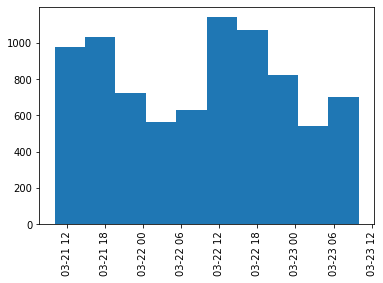

In [279]:
plt.hist(posts['created'])
plt.xticks(rotation=90)
plt.show()

#### There is a periodic pattern according to the plot. The number of submissions mainly concentrate between 12 to 18 which is afternoon time.

#### Count the hot words and filtering out the stoping words and numbers in submissions' title

In [210]:
from stop_words import get_stop_words
import nltk
from nltk.corpus import stopwords

In [215]:
stop_words = list(get_stop_words('en'))         
nltk_words = list(stopwords.words('english'))   
stop_words.extend(nltk_words)
stop_words.extend([1,2,3,4,5,6,7,8,9])

In [280]:
dic={}
for title in posts.title:
    sentence=title.split()
    for word in sentence:
        if word in stop_words:
            continue
        if bool(re.search(r'[0-9]',word)):
            continue
        if word not in dic:
            dic[word]=1
        else:
            dic[word]+=1
dic=sorted(dic.items(),key=lambda d:d[1],reverse=True)

In [281]:
### Set the order number
submission_list={}
limit=30
for i in dic:
    print("The",31-limit,'hot word is', i)
    submission_list[i[0]]=1
    limit-=1
    if limit==0:
        break

The 1 hot word is ('coronavirus', 2954)
The 2 hot word is ('covid', 1335)
The 3 hot word is ('cases', 917)
The 4 hot word is ('new', 689)
The 5 hot word is ('people', 581)
The 6 hot word is ('virus', 489)
The 7 hot word is ('italy', 394)
The 8 hot word is ('positive', 381)
The 9 hot word is ('home', 367)
The 10 hot word is ('india', 319)
The 11 hot word is ('stay', 312)
The 12 hot word is ('help', 300)
The 13 hot word is ('china', 300)
The 14 hot word is ('corona', 292)
The 15 hot word is ('pandemic', 288)
The 16 hot word is ('deaths', 273)
The 17 hot word is ('usa', 264)
The 18 hot word is ('says', 261)
The 19 hot word is ('first', 258)
The 20 hot word is ('lockdown', 251)
The 21 hot word is ('total', 245)
The 22 hot word is ('health', 245)
The 23 hot word is ('test', 236)
The 24 hot word is ('quarantine', 225)
The 25 hot word is ('masks', 225)
The 26 hot word is ('death', 223)
The 27 hot word is ('world', 216)
The 28 hot word is ('tests', 213)
The 29 hot word is ('medical', 206)
The 

#### do the same thing in comments

In [282]:
dic_comment={}
for title in comment.comment:
    sentence=title.split()
    for word in sentence:
        if word in stop_words:
            continue
        if bool(re.search(r'[0-9]',word)):
            continue
        if word not in dic_comment:
            dic_comment[word]=1
        else:
            dic_comment[word]+=1
dic_comment=sorted(dic_comment.items(),key=lambda d:d[1],reverse=True)

In [283]:
comment_list={}
limit=30
for i in dic_comment:
    print("The",31-limit,'hot word is', i)
    comment_list[i[0]]=1
    limit-=1
    if limit==0:
        break

The 1 hot word is ('people', 8155)
The 2 hot word is ('like', 3990)
The 3 hot word is ('get', 3743)
The 4 hot word is ('going', 2702)
The 5 hot word is ('one', 2682)
The 6 hot word is ('cases', 2624)
The 7 hot word is ('virus', 2592)
The 8 hot word is ('time', 2306)
The 9 hot word is ('need', 2288)
The 10 hot word is ('https', 2172)
The 11 hot word is ('still', 2109)
The 12 hot word is ('even', 2099)
The 13 hot word is ('good', 1962)
The 14 hot word is ('go', 1961)
The 15 hot word is ('coronavirus', 1944)
The 16 hot word is ('know', 1910)
The 17 hot word is ('home', 1861)
The 18 hot word is ('work', 1746)
The 19 hot word is ('many', 1725)
The 20 hot word is ('china', 1674)
The 21 hot word is ('think', 1666)
The 22 hot word is ('really', 1581)
The 23 hot word is ('see', 1562)
The 24 hot word is ('right', 1552)
The 25 hot word is ('com', 1529)
The 26 hot word is ('also', 1516)
The 27 hot word is ('us', 1497)
The 28 hot word is ('day', 1462)
The 29 hot word is ('days', 1448)
The 30 hot wo

In [284]:
print('The common top word in both submission and comment is:')
for i in submission_list:
    if i in comment_list:
        print(i)

The common top word in both submission and comment is:
coronavirus
cases
new
people
virus
home
china


#### We can see that in submission title and comment body, people are focusing most on "coronavirus " and the country that have been referenced the most is China. Also people focus a lot on people and home and number of cases. Especially new cases.

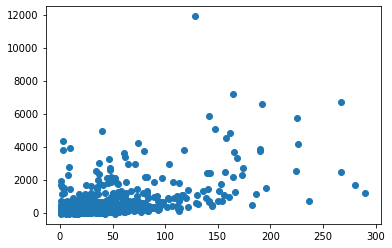

In [300]:
plt.scatter(comment.subcomments_num,comment.score)

In [302]:
posts.score.value_counts()

1    8153
2      46
0       7
Name: score, dtype: int64

#### In the comments, there is a slight trend that the larger the subcomments number is, the more likely it can havea higher score. In the submissions, most submissions are scored 1.

## Use LDA to cluster the topic and see what may contribute to the difference

In [306]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [337]:
cntVector=CountVectorizer()
topic = cntVector.fit_transform(posts.title)

In [308]:
lda = LatentDirichletAllocation(n_components=2,learning_offset=66,random_state=666)

In [309]:
cluster_result = lda.fit_transform(topic)

In [315]:
posts_cluster=cluster_result[:,0]

In [319]:
for i,obj in enumerate(posts_cluster):
    if obj>0.5:
        posts_cluster[i]=1
    else:
        posts_cluster[i]=0
posts_cluster

array([0., 0., 1., ..., 0., 1., 1.])

In [320]:
posts['cluster']=posts_cluster

In [323]:
posts.groupby('cluster')['score','numComms'].mean()

,score,numComms
cluster,,
0.0,1.004374,26.696738
1.0,1.005517,14.205223


In [330]:
def output_hotword(posts):
    dic={}
    for title in posts.title:
        sentence=title.split()
        for word in sentence:
            if word in stop_words:
                continue
            if bool(re.search(r'[0-9]',word)):
                continue
            if word not in dic:
                dic[word]=1
            else:
                dic[word]+=1
    dic=sorted(dic.items(),key=lambda d:d[1],reverse=True)
    comment_list={}
    limit=30
    for i in dic:
        print("The",31-limit,'hot word is', i)
        comment_list[i[0]]=1
        limit-=1
        if limit==0:
            break
    return comment_list

### Hot words of posts clustered 0

In [331]:
posts_1=output_hotword(posts[posts['cluster']==0])

The 1 hot word is ('coronavirus', 1715)
The 2 hot word is ('cases', 641)
The 3 hot word is ('covid', 563)
The 4 hot word is ('people', 536)
The 5 hot word is ('new', 531)
The 6 hot word is ('italy', 372)
The 7 hot word is ('virus', 354)
The 8 hot word is ('home', 343)
The 9 hot word is ('stay', 305)
The 10 hot word is ('help', 268)
The 11 hot word is ('india', 251)
The 12 hot word is ('deaths', 230)
The 13 hot word is ('china', 225)
The 14 hot word is ('corona', 211)
The 15 hot word is ('lockdown', 211)
The 16 hot word is ('masks', 207)
The 17 hot word is ('total', 206)
The 18 hot word is ('health', 205)
The 19 hot word is ('pandemic', 203)
The 20 hot word is ('says', 199)
The 21 hot word is ('quarantine', 186)
The 22 hot word is ('usa', 180)
The 23 hot word is ('medical', 177)
The 24 hot word is ('workers', 175)
The 25 hot word is ('state', 167)
The 26 hot word is ('positive', 165)
The 27 hot word is ('spread', 160)
The 28 hot word is ('day', 150)
The 29 hot word is ('march', 150)
The

### Hot words of posts clustered 1

In [332]:
posts_2=output_hotword(posts[posts['cluster']==1])

The 1 hot word is ('coronavirus', 1239)
The 2 hot word is ('covid', 772)
The 3 hot word is ('cases', 276)
The 4 hot word is ('positive', 216)
The 5 hot word is ('new', 158)
The 6 hot word is ('tests', 153)
The 7 hot word is ('first', 150)
The 8 hot word is ('test', 145)
The 9 hot word is ('virus', 135)
The 10 hot word is ('death', 116)
The 11 hot word is ('confirmed', 87)
The 12 hot word is ('news', 85)
The 13 hot word is ('pandemic', 85)
The 14 hot word is ('usa', 84)
The 15 hot word is ('corona', 81)
The 16 hot word is ('world', 79)
The 17 hot word is ('case', 79)
The 18 hot word is ('china', 75)
The 19 hot word is ('trump', 74)
The 20 hot word is ('live', 72)
The 21 hot word is ('india', 68)
The 22 hot word is ('testing', 63)
The 23 hot word is ('says', 62)
The 24 hot word is ('county', 59)
The 25 hot word is ('weinstein', 58)
The 26 hot word is ('harvey', 57)
The 27 hot word is ('tested', 54)
The 28 hot word is ('get', 53)
The 29 hot word is ('amid', 51)
The 30 hot word is ('treatm

In [335]:
### difference between cluster 0 and 1
## In posts_1 not posts_2
print('In cluster posts_0 not posts_1')
for i in posts_1:
    if i not in posts_2:
        print(i)

print('\n')
## In posts_2 not posts_1
print('In cluster posts_1 not posts_0')
for i in posts_2:
    if i not in posts_1:
        print(i)

In cluster posts_0 not posts_1
people
italy
home
stay
help
deaths
lockdown
masks
total
health
quarantine
medical
workers
state
spread
day
march
days


In cluster posts_1 not posts_0
tests
first
test
death
confirmed
news
world
case
trump
live
testing
county
weinstein
harvey
tested
get
amid
treatment


### Posts of cluster 0 gains more comments. The words it have that may contribute to that are listed above. Thus we can see that people care about 'people' and 'italy' a lot  and trump and death are not quite considered. Same thing can be done in comments.